In [1]:
import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
import os

from sde4mbrl.nsde import ControlledSDE, create_sampling_fn

%matplotlib widget

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

In [2]:
# A simple linear stochastic system with known dynamics
class LinSDE(ControlledSDE):
    def __init__(self, params, name=None):
        # Define the params here if needed before initialization
        super().__init__(params, name)
    
    # The dynamics is known so the prior function is equal 
    # to the posterior function
    def prior_drift(self, t, x, u):
        return 3*x + u
    
    # We set the posterior function to be the same as the prior function
    posterior_drift = prior_drift
    
    # The noise in the dynamics
    def prior_diffusion(self, t, x):
        return jnp.array([4.])

# Define a suboptimal policy for this process
# It will be used to generate trajectories
def u_subopt(t, x):
    return ((3*jnp.exp(8*t-8) - 7)*x / (1 + 3*jnp.exp(8*t-8))) * jnp.exp(2*(t-1)) 
    # The last exponential enforces suboptimality

In [3]:
# Define the number of particles for each solvers
num_particles = 1000
# define the time step during integration
stepsize = 0.01
# Define the time indexes by each solver
ts = jnp.linspace(0, 1., int(1./stepsize))
# Initial state
xinit = jnp.array([0.5])
# Initial random number generator
rng = jax.random.PRNGKey(0)
rng, s_rng = jax.random.split(rng)

In [4]:
# My implementation of the sdesolver 9assuming they follow stratonovich formulation) -> Milstein
# First obtain a function to sample from the library
_stupid_params = {'sde_solver' : 'stratonovich_milstein', 'n_y' : 1, 'n_u' : 1, 'n_x' : 1, 'num_particles' : num_particles}
_params, sampling_fn = create_sampling_fn(_stupid_params, sde_constr=LinSDE, prior_sampling=False, seed=10)
# Jit the function to sample
jit_sampling_fn = jax.jit(lambda t, x, rng_val:  sampling_fn(_params, t, x, u_subopt, rng_val))
x_evol_milstein, u_mil = jit_sampling_fn(ts, xinit, s_rng)

In [5]:
# My implementation of the sdesolver 9assuming they follow stratonovich formulation) -> Heun
# First obtain a function to sample from the library
_stupid_params = {'sde_solver' : 'stratonovich_heun', 'n_y' : 1, 'n_u' : 1, 'n_x' : 1, 'num_particles' : num_particles}
_params_heun, sampling_fn_heun = create_sampling_fn(_stupid_params, sde_constr=LinSDE, prior_sampling=False, seed=10)
# Jit the function to sample
jit_sampling_fn_heun = jax.jit(lambda t, x, rng_val:  sampling_fn_heun(_params_heun, t, x, u_subopt, rng_val))
x_evol_heun, u_heun = jit_sampling_fn_heun(ts, xinit, s_rng)

In [6]:
# Let use diffrax implementation to compare the results and see if everything looks fine
import diffrax
from diffrax import diffeqsolve, MultiTerm, ODETerm, SaveAt, UnsafeBrownianPath

drift_fn = lambda t, x, args: 3*x + u_subopt(t, x)
diff_fn = lambda t, x, args: jnp.array(4.)
def solve_sde(xinit, _rng):
    brownian_motion = UnsafeBrownianPath(shape=(1,), key=_rng)
    # terms = MultiTerm(ODETerm(drift), diffrax.WeaklyDiagonalControlTerm(diff_fn, brownian_motion))
    terms = (ODETerm(drift_fn), diffrax.WeaklyDiagonalControlTerm(diff_fn, brownian_motion) )
    solver = diffrax.StratonovichMilstein()
    sol = diffeqsolve(terms, solver, ts[0], ts[-1], dt0=stepsize, y0=xinit, saveat=SaveAt(ts=ts), adjoint=diffrax.NoAdjoint())
    return sol.ys
jit_sampling_diffrax = jax.jit(jax.vmap(solve_sde, in_axes=(None,0)))
x_evol_diffrax_milstein = jit_sampling_diffrax(xinit, jax.random.split(s_rng, num_particles))

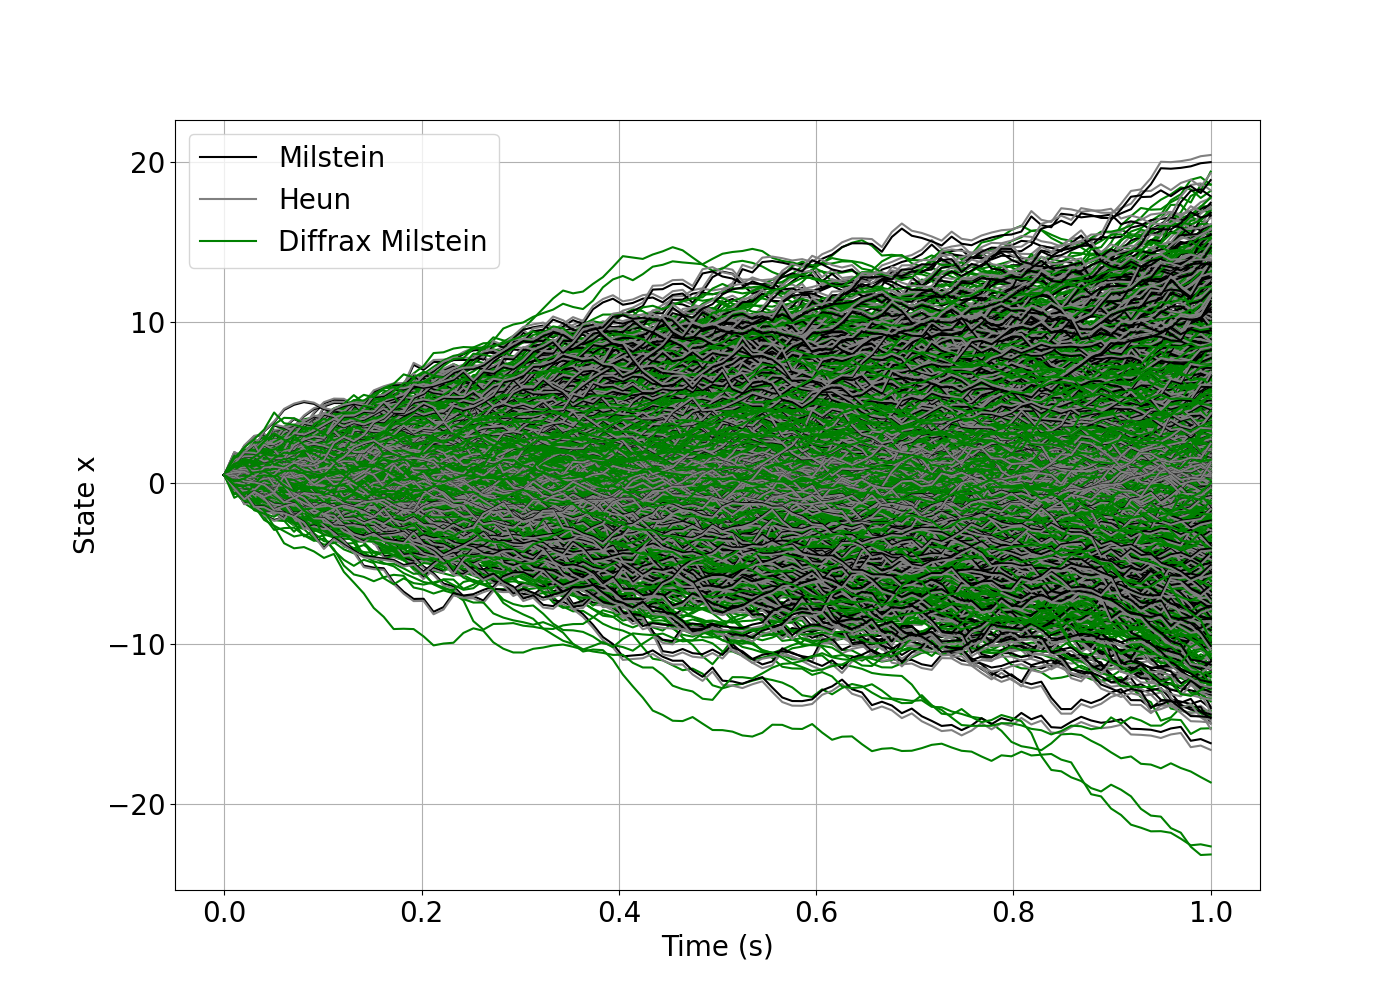

In [7]:
# Set the font size in the problem
plt.rcParams.update({'font.size': 20})

# DO some plotting
fig, ax = plt.subplots(figsize=(14, 10))
for i in range(num_particles):
    if i == 0:
        plt.plot(ts, x_evol_milstein[i,:,0], label='Milstein', color='black')
        plt.plot(ts, x_evol_heun[i,:,0], label='Heun', color='gray')
        plt.plot(ts, x_evol_diffrax_milstein[i,:,0], label='Diffrax Milstein', color='green')
    else:
        plt.plot(ts, x_evol_milstein[i,:,0],  color='black')
        plt.plot(ts, x_evol_heun[i,:,0], color='gray')
        plt.plot(ts, x_evol_diffrax_milstein[i,:,0],  color='green')
            
plt.ylabel('State x')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()